## Multi-class classifier

In [55]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torch.backends.mps
import matplotlib.pyplot as plt

In [10]:
#--- hyperparameters ---
N_EPOCHS = 10
LR = 0.001
DROPOUT_RATE = 0.3

#--- fixed constants ---
NUM_CLASSES = 14
DATA_DIR = 'dataset/%s'
NUM_CHANNELS = 3
WIDTH, HEIGHT = 128, 128
MEAN = [0.45183619, 0.4171191, 0.3778775 ]
SD = [0.24016619, 0.23024313, 0.22750713]

In [11]:
train_transform = transforms.Compose([
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomResizedCrop(128),
                                        #transforms.Grayscale(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(MEAN, SD)])
val_transform = transforms.Compose([
                                        #transforms.Grayscale(),
                                        transforms.Resize(256),
                                        transforms.CenterCrop(128),
                                        transforms.ToTensor(),
                                        transforms.Normalize(MEAN, SD)])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(MEAN, SD)])

In [60]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(os.path.join(self.root_dir, "images")))
        self.labels = {}
        for label in ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']:
            with open(os.path.join(self.root_dir, "annotations", f"{label}.txt"), "r") as f:
                f.seek(0)
                self.labels[label] = sorted(set(f.read().splitlines()))
                # self.labels[label] = set(f.read().splitlines()) # this is original

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, "images", self.image_paths[index])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = []
        for key, value in self.labels.items():
            filename = os.path.basename(image_path)[2:-4]
            #print(filename)
            label.append(1 if filename in value else 0)

        label = torch.tensor(label, dtype=torch.float32)
        #print(label.shape)
        return image, label, index, image_path
        

In [42]:
# set here the path where the images and annotations are
path = "/home/vixmaria/koulu/IDL/projekti/IntroToDL-main/dataset"

# load the data
dataset = CustomDataset(path, transform=None)

# Define the sizes of the splits
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset randomly into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset = CustomDataset(path, transform=train_transform)
val_dataset.dataset = CustomDataset(path, transform=val_transform)
test_dataset.dataset = CustomDataset(path, transform=test_transform)


# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [43]:
class MultiLabelClassifier(nn.Module):
    def __init__(self):
        super(MultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(NUM_CHANNELS, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.drop(x)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [44]:
model = MultiLabelClassifier()

device = torch.device('cpu')

# set up device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = torch.device('mps')


print(device)

model = MultiLabelClassifier().to(device)

# Define your loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)
threshold = 0.5

# parameters for early stop
threshold = 1       # number of epochs to wait if test loss doesnt improve
min_loss = np.inf
counter = 0

# Train your model
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0
    total_zero = 0

    model.train()
    for i, data in enumerate(train_loader):
        #print()
        inputs, labels, index, path = data
        #print(labels.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        #print(labels.shape)
        
        # calculate accuracy
        predictions = (outputs > 0.5).int()
        correct = torch.eq(predictions, labels).sum().item()

        train_correct += correct

        # En oo iha varma miten tätä pitäs tulkita, atm laskee siis jokasen oikeen arvauksen ja yhen kuvan sisällä on käytännössä 14 arvausta
        train_total += labels.size(0)*NUM_CLASSES

        loss = criterion(outputs, labels)
        train_loss += loss
        loss.backward()
        optimizer.step()

        if predictions.sum() == 0:
            total_zero += 1

        # print('predictions',predictions)
        # print('labels',labels)
    
    # calculate average loss and accuracy for epoch
    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = train_correct / train_total
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    # evaluate model on validation set
    with torch.no_grad():
        val_loss = 0
        val_correct = 0
        val_total = 0
        total_zero = 0

        for i, data in enumerate(val_loader):
            inputs, labels, index, path = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            # calculate accuracy
            predictions = (outputs > 0.5).int()
            correct = torch.eq(predictions, labels).sum().item()
            val_correct += correct

            val_total += labels.size(0)*NUM_CLASSES
            val_loss += loss

            if predictions.sum() == 0:
                total_zero += 1

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    # early stopping
    if val_loss < min_loss:
        min_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= threshold:
            print(f'Stopping early after epoch {epoch}, best loss reached.')
            break
            

cpu

torch.Size([32, 14])
torch.Size([32, 14])

torch.Size([32, 14])
torch.Size([32, 14])

torch.Size([32, 14])
torch.Size([32, 14])

torch.Size([32, 14])
torch.Size([32, 14])

torch.Size([32, 14])
torch.Size([32, 14])

torch.Size([32, 14])
torch.Size([32, 14])

torch.Size([32, 14])
torch.Size([32, 14])

torch.Size([32, 14])
torch.Size([32, 14])

torch.Size([32, 14])
torch.Size([32, 14])


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [45]:
model = MultiLabelClassifier().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [64]:
#--- test ---

with torch.no_grad():
    test_loss = 0
    test_correct = 0
    test_total = 0
    total_zero = 0
    for i, data in enumerate(test_loader):
        inputs, labels, index, path = data
        inputs, labels = inputs.to(device), labels.to(device)
        #print(labels.shape)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        # calculate accuracy
        predictions = (outputs > 0.5).int()
        
        correct = torch.eq(predictions, labels).sum().item()
        test_correct += correct

        test_total += labels.size(0)*NUM_CLASSES
        test_loss += loss

        if predictions.sum() == 0:
            total_zero += 1

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')
print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

Test Loss: 0.694 |  Test Acc: 92.97%
63
63


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


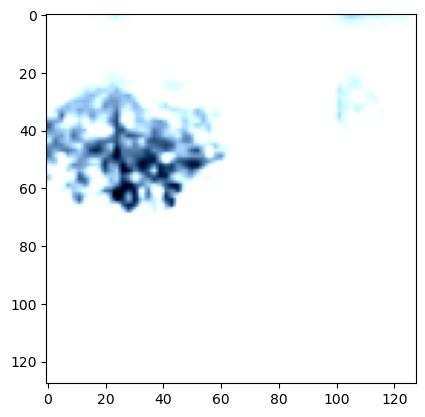

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


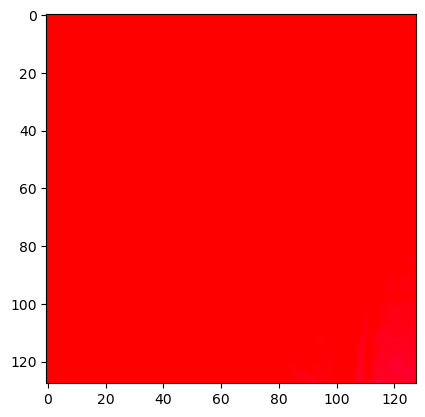

['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


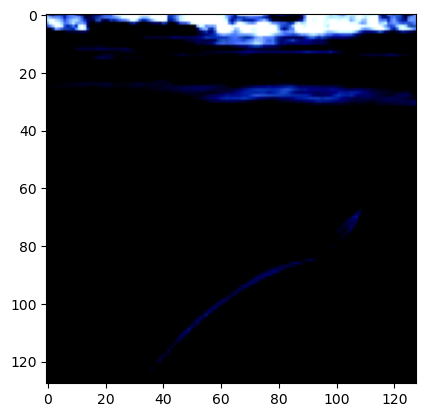

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


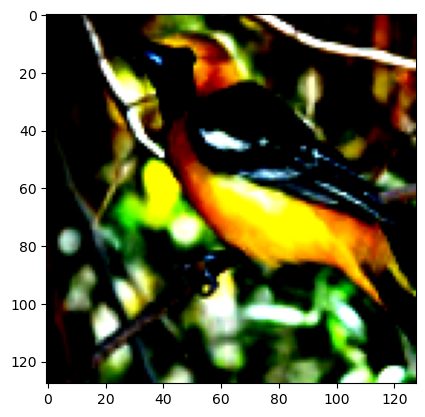

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


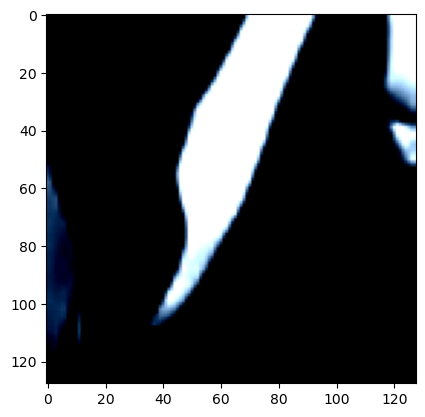

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


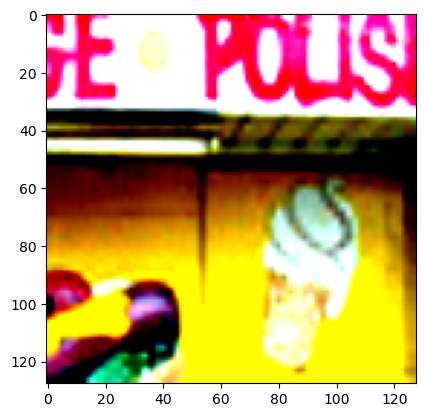

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


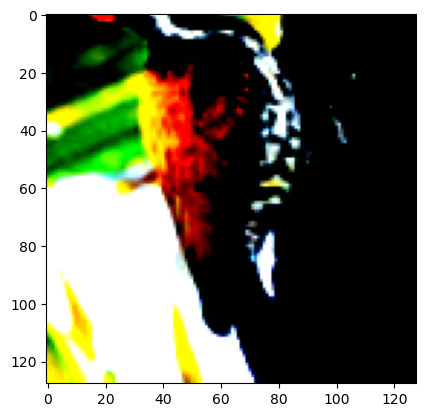

['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


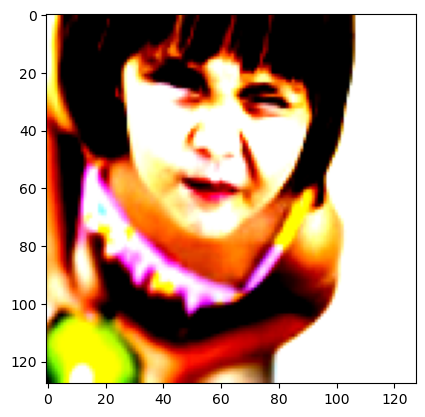

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


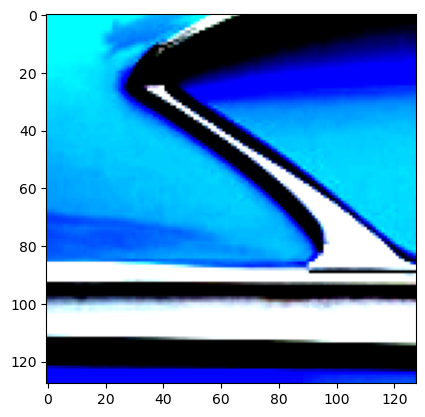

['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


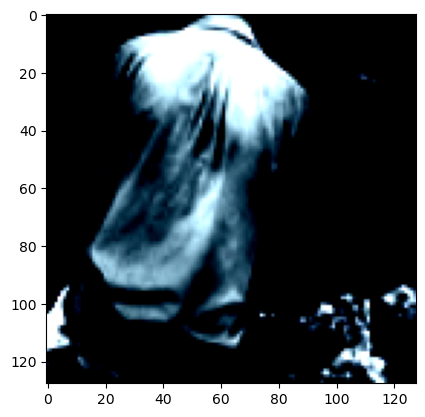

In [66]:
def testN(num_pics):
    test_total = 0
    test_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    for i, data in enumerate(test_loader):
        test_total += 1
        if test_total > num_pics:
            break
        input, label, index, path = data
        input, label = input.to(device), label.to(device)
        output = model.forward(input)
        predictions = (output > 0.5).int()

        print(['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree'])
        print('label',label)
        print()
        print('pred', predictions)

        image_array = input.numpy()
        plt.imshow(image_array.transpose((2, 3, 1, 0)).squeeze(3))
        plt.show()


testN(10)